In [1]:
### APO Minimization and Equilibration test ###

In [17]:
# imports
from SBLMDCOVDOCK import SBLSettings
from SBLMDCOVDOCK.md_setuptools import plot_xvg

settings = SBLSettings.GROMACS_Settings()

import pandas as pd
import os

import gmxapi as gmx
import subprocess
import matplotlib.pyplot as plt
#collect APO structures 

# AMPC - https://journals.asm.org/doi/10.1128/AAC.02073-20
ampc = "6T3D"
# KPC-2 - BLDB: http://dx.doi.org/10.1021/ACS.JMEDCHEM.7B00158
kpc2 = "5UL8"
# OXA-10 - BLDB: https://www.pnas.org/doi/full/10.1073/pnas.241442898
oxa10 = "1K55"

structures = pd.DataFrame({"PDBID": [ampc, kpc2, oxa10], 
                           "Name": ["AmpC", "KPC2", "OXA10"]})
settings.structures_output = os.path.join(settings.structures_output, 'amber14')
os.makedirs(settings.structures_output, exist_ok=True)
print(settings.structures_output)

prod_structures/APO/amber14


In [18]:
!ls amber14sb.ff

Makefile.am      aminoacids.vsd   forcefield.doc   spc.itp
Makefile.in      atomtypes.atp    forcefield.itp   spce.itp
aminoacids.arn   dna.arn          gbsa.itp         tip3p.itp
aminoacids.c.tdb dna.hdb          ions.itp         tip4p.itp
aminoacids.hdb   dna.r2b          rna.arn          tip4pew.itp
aminoacids.n.tdb dna.rtp          rna.hdb          tip5p.itp
aminoacids.r2b   ffbonded.itp     rna.r2b          urea.itp
aminoacids.rtp   ffnonbonded.itp  rna.rtp          watermodels.dat


In [19]:
amber14sb_ff_path = os.path.join(os.getcwd())

# Set the GMXLIB environment variable
os.environ["GMXLIB"] = amber14sb_ff_path

In [20]:
# Create Box, Solvate, add Ions
for pdbcode in structures.PDBID:
    break # tested working 
    print(pdbcode)  
    # Input path
    input_path = os.path.join(settings.structures_output, "APO_" + pdbcode + ".gro")
    print(input_path)
    # break
    # Output paths
    box_output_path = input_path.replace(".gro", "_box.pdb")

    # Define the editconf command
    editconf_command = ["gmx", "editconf", "-f", input_path, "-o", box_output_path, "-c", "-d", "1.0", "-bt", "cubic"]

    # Run the editconf command
    subprocess.run(editconf_command, check=True) 
    # subprocess.run(editconf_command.replace(".pdb",".gro"), check=True) 


    solvated_output_path = input_path.replace(".gro", "_solv.gro")

    topo_path = input_path.replace(".gro", ".top")

    # Define the solvate command
    solvate_command = ["gmx", "solvate", "-cp", box_output_path, "-cs", "spc216.gro", "-p", topo_path, "-o", solvated_output_path]

    # Run the solvate command
    subprocess.run(solvate_command, check=True)

    ion_MDP = os.path.join(settings.config, "ions.mdp")
    # Generate tpr for genion
    grompp_command = ["gmx", "grompp", "-f", ion_MDP, "-c", solvated_output_path, "-p", topo_path, "-o", solvated_output_path.replace(".gro", ".tpr")]

    # Run the grompp command
    subprocess.run(grompp_command, check=True)

    ionised_output_path = solvated_output_path.replace(".gro", "_ion.gro")

    # Define the genion command
    genion_command = ["gmx", "genion", "-s", solvated_output_path.replace(".gro", ".tpr"), "-o", ionised_output_path, "-p", topo_path, "-pname", "NA", "-nname", "CL", "-neutral", "-conc", "0.15"]

    # Run the genion command
    subprocess.run(genion_command, input='SOL\n', check=True, text=True)

    # break


6T3D
prod_structures/APO/amber14/APO_6T3D.gro
Note that major changes are planned in future for editconf, to improve usability and utility.
Read 5581 atoms
Volume: 213.522 nm^3, corresponds to roughly 96000 electrons
No velocities found
    system size :  6.040  5.090  5.340 (nm)
    diameter    :  7.319               (nm)
    center      : -1.637  0.492  2.615 (nm)
    box vectors :  6.540  5.590  5.840 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 213.52               (nm^3)
    shift       :  6.296  4.167  2.045 (nm)
new center      :  4.659  4.659  4.659 (nm)
new box vectors :  9.319  9.319  9.319 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 809.20               (nm^3)

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
    

                     :-) GROMACS - gmx editconf, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /Users/alexi/Library/CloudStorage/OneDrive-Nexus365/Rotation_Projects/Rotation_2/Project/SBL_MD_CovDock
Command line:
  gmx editconf -f prod_structures/APO/amber14/APO_6T3D.gro -o prod_structures/APO/amber14/APO_6T3D_box.pdb -c -d 1.0 -bt cubic


GROMACS reminds you: "This May Come As a Shock" (F. Black)

                     :-) GROMACS - gmx solvate, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /Users/alexi/Library/CloudStorage/OneDrive-Nexus365/Rotation_Projects/Rotation_2/Project/SBL_MD_CovDock
Command line:
  gmx solvate -cp prod_structures/APO/amber14/APO_6T3D_box.pdb -cs spc216.gro -p prod_structures/APO/amber14/APO_6T3D.top -o prod_structures/APO/amber14/APO_6T3D_solv.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...
Generat

Adding line for 24817 solvent molecules with resname (SOL) to topology file (prod_structures/APO/amber14/APO_6T3D.top)


Number of degrees of freedom in T-Coupling group rest is 165642.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

NOTE 3 [file config/ions.mdp]:
  You are using a plain Coulomb cut-off, which might produce artifacts.
  You might want to consider using PME electrostatics.



There were 3 NOTEs

GROMACS reminds you: "Take what you want, but just what you need for survival" (Joe Jackson)

                      :-) GROMACS - gmx genion, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /Users/alexi/Library/CloudStorage/OneDrive-Nexus365/Rotation_Projects/Rotation_2/Project/SBL_MD_CovDock
Command line:
  gmx genion -s prod_structures/APO/amber14/APO_6T3D_solv.tpr -o prod_structures/APO/amber14/APO_6T3D_solv_ion.gro -p prod_structures/APO/amber14/APO_6T3D.top -pname NA -nname CL -neutral -conc 0.15

Reading file prod_structures/APO/amber14/APO_6T3D_solv.tpr, VERSION 2023.2 (single precision)
R

Setting the LD random seed to 2008771452

Generated 3570 of the 3570 non-bonded parameter combinations

Generated 3570 of the 3570 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'system1'

Excluding 2 bonded neighbours molecule type 'SOL'
Analysing residue names:
There are:   358    Protein residues
There are: 24817      Water residues
Analysing Protein...

This run will generate roughly 6 Mb of data
Will try to add 73 NA ions and 76 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 149 solute molecules in topology file (prod_structures/APO/amber14/APO_6T3D.top)  by 73 NA and 76 CL ions.
5UL8
prod_structures/APO/amber14/APO_5UL8.gro
Note that major changes are planned in future for editconf, to improve usability and utility.
Read 4034 atoms
Volume: 152.571 nm^3, corresponds to roughly 68600 electrons
No velocities found
    system size :  5.796  4.025  4.855 (nm)
    diameter    :  6.241               (nm)

Generated solvent containing 51165 atoms in 17055 residues
Writing generated configuration to prod_structures/APO/amber14/APO_5UL8_solv.gro

Output configuration contains 55199 atoms in 17326 residues
Volume                 :     559.578 (nm^3)
Density                :     1002.98 (g/l)
Number of solvent molecules:  17055   

Processing topology

Back Off! I just backed up prod_structures/APO/amber14/APO_5UL8.top to prod_structures/APO/amber14/#APO_5UL8.top.1#

GROMACS reminds you: "Take what you want, but just what you need for survival" (Joe Jackson)

                      :-) GROMACS - gmx grompp, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /Users/alexi/Library/CloudStorage/OneDrive-Nexus365/Rotation_Projects/Rotation_2/Project/SBL_MD_CovDock
Command line:
  gmx grompp -f config/ions.mdp -c prod_structures/APO/amber14/APO_5UL8_solv.gro -p prod_structures/APO/amber14/APO_5UL8.top -o prod_structures/APO/amber14/APO_5UL8_solv.tpr


Adding line for 17055 solvent molecules with resname (SOL) to topology file (prod_structures/APO/amber14/APO_5UL8.top)
Setting the LD random seed to -67552784

Generated 3570 of the 3570 non-bonded parameter combinations

Generated 3570 of the 3570 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'system1'

Excluding 2 bonded neighbours molecule type 'SOL'
Analysing residue names:
There are:   271    Protein residues
There are: 17055      Water residues
Analysing Protein...

This run will generate roughly 4 Mb of data



NOTE 2 [file APO_5UL8.top, line 44617]:
  System has non-zero total charge: -1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.



Number of degrees of freedom in T-Coupling group rest is 114429.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

NOTE 3 [file config/ions.mdp]:
  You are using a plain Coulomb cut-off, which might produce artifacts.
  You might want to consider using PME electrostatics.



There were 3 NOTEs

GROMACS reminds you: "Take what you want, but just what you need for survival" (Joe Jackson)

                      :-) GROMACS - gmx genion, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /Users/alexi/Library/CloudStorage/OneDrive-Nexus365/Rotation_Projects/Rotation_2/Project/SBL_MD_CovDock
Command line:
  gmx genion -s prod_structures/

Will try to add 52 NA ions and 51 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 103 solute molecules in topology file (prod_structures/APO/amber14/APO_5UL8.top)  by 52 NA and 51 CL ions.
1K55
prod_structures/APO/amber14/APO_1K55.gro
Note that major changes are planned in future for editconf, to improve usability and utility.
Read 3870 atoms
Volume: 136.197 nm^3, corresponds to roughly 61200 electrons
No velocities found
    system size :  3.965  4.756  5.301 (nm)
    diameter    :  5.809               (nm)
    center      :  1.836  0.932  4.138 (nm)
    box vectors :  4.466  5.257  5.802 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 136.20               (nm^3)
    shift       :  2.069  2.972 -0.233 (nm)
new center      :  3.905  3.905  3.905 (nm)
new box vectors :  7.809  7.809  7.809 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 476.27               (nm^3)

         based on

Removed 6885 solvent atoms due to solvent-solvent overlap
Removed 3459 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms): 14477 residues
Generated solvent containing 43431 atoms in 14477 residues
Writing generated configuration to prod_structures/APO/amber14/APO_1K55_solv.gro

Output configuration contains 47301 atoms in 14722 residues
Volume                 :      476.27 (nm^3)
Density                :     1011.78 (g/l)
Number of solvent molecules:  14477   

Processing topology

Back Off! I just backed up prod_structures/APO/amber14/APO_1K55.top to prod_structures/APO/amber14/#APO_1K55.top.1#

GROMACS reminds you: "Sir, spare your threats: The bug which you would fright me with I seek." (Hermione, Act III, scene II of Shakespeare's Winter's Tale)

                      :-) GROMACS - gmx grompp, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /Users/alexi/Library/CloudStorag

Setting the LD random seed to 2122186591

Generated 3570 of the 3570 non-bonded parameter combinations

Generated 3570 of the 3570 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'system1'

Excluding 2 bonded neighbours molecule type 'SOL'
Analysing residue names:
There are:   245    Protein residues
There are: 14477      Water residues
Analysing Protein...

This run will generate roughly 4 Mb of data
Will try to add 45 NA ions and 43 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 88 solute molecules in topology file (prod_structures/APO/amber14/APO_1K55.top)  by 45 NA and 43 CL ions.



NOTE 2 [file APO_1K55.top, line 42762]:
  System has non-zero total charge: -2.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.



Number of degrees of freedom in T-Coupling group rest is 98469.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

NOTE 3 [file config/ions.mdp]:
  You are using a plain Coulomb cut-off, which might produce artifacts.
  You might want to consider using PME electrostatics.



There were 3 NOTEs

GROMACS reminds you: "Sir, spare your threats: The bug which you would fright me with I seek." (Hermione, Act III, scene II of Shakespeare's Winter's Tale)

                      :-) GROMACS - gmx genion, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /Users/alexi/Library/CloudStorage/OneDrive-Nexus365/Rotation_Projects/Rotation_2/Project

                      :-) GROMACS - gmx grompp, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /Users/alexi/Library/CloudStorage/OneDrive-Nexus365/Rotation_Projects/Rotation_2/Project/SBL_MD_CovDock
Command line:
  gmx grompp -f config/minim.mdp -c prod_structures/APO/amber14/APO_6T3D_solv_ion.gro -p prod_structures/APO/amber14/APO_6T3D.top -o prod_structures/APO/amber14/APO_6T3D_min.tpr

Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file config/minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group rest is 165195.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

There was 1 NOTE

GROMACS reminds you: "Read me your scripture and I will twist it" (Red Hot Chili Peppers)

      

Setting the LD random seed to 937426943

Generated 3570 of the 3570 non-bonded parameter combinations

Generated 3570 of the 3570 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'system1'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 1 bonded neighbours molecule type 'NA'

Excluding 1 bonded neighbours molecule type 'CL'
Analysing residue names:
There are:   358    Protein residues
There are: 24668      Water residues
There are:   149        Ion residues
Analysing Protein...

The largest distance between excluded atoms is 0.416 nm between atom 5203 and 5211
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 80x80x80, spacing 0.116 0.116 0.116

Estimate for the relative computational load of the PME mesh part: 0.22

This run will generate roughly 6 Mb of data



Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =        50000
Step=    0, Dmax= 1.0e-02 nm, Epot= -8.27527e+05 Fmax= 1.94935e+05, atom= 4097
Step=    1, Dmax= 1.0e-02 nm, Epot= -8.60077e+05 Fmax= 6.85854e+04, atom= 29033
Step=    2, Dmax= 1.2e-02 nm, Epot= -9.02857e+05 Fmax= 2.65925e+04, atom= 29033
Step=    3, Dmax= 1.4e-02 nm, Epot= -9.51383e+05 Fmax= 1.07797e+04, atom= 42542
Step=    4, Dmax= 1.7e-02 nm, Epot= -9.95684e+05 Fmax= 4.84320e+03, atom= 42542
Step=    5, Dmax= 2.1e-02 nm, Epot= -1.02836e+06 Fmax= 1.71320e+04, atom= 4095
Step=    6, Dmax= 2.5e-02 nm, Epot= -1.04383e+06 Fmax= 1.99251e+04, atom= 3739
Step=    7, Dmax= 3.0e-02 nm, Epot= -1.05162e+06 Fmax= 2.50178e+04, atom= 3739
Step=    8, Dmax= 3.6e-02 nm, Epot= -1.05811e+06 Fmax= 2.89677e+04, atom= 3739
Step=    9, Dmax= 4.3e-02 nm, Epot= -1.06310e+06 Fmax= 3.53367e+04, atom= 3739
Step=   10, Dmax= 5.2e-02 nm, Epot= -1.06749e+06 Fmax= 4.14038e+04, atom= 3739
Step=   11, Dmax= 6.2e-02 nm, Epo


Statistics over 980 steps [ 0.0000 through 979.0000 ps ], 1 data sets
All statistics are over 776 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                -1.23952e+06      19000    48089.8    -126352  (kJ/mol)



Steepest Descents converged to Fmax < 1000 in 980 steps
Potential Energy  = -1.2772374e+06
Maximum force     =  9.8466107e+02 on atom 101
Norm of force     =  1.6752087e+01

GROMACS reminds you: "It was something to at least have a choice of nightmares" (Joseph Conrad)

                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /Users/alexi/Library/CloudStorage/OneDrive-Nexus365/Rotation_Projects/Rotation_2/Project/SBL_MD_CovDock
Command line:
  gmx energy -f prod_structures/APO/amber14/APO_6T3D_min.edr -o prod_structures/APO/amber14/APO_6T3D_min_energy.xvg

Opened prod_structures/APO/amber14/APO_6T3D_min.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             

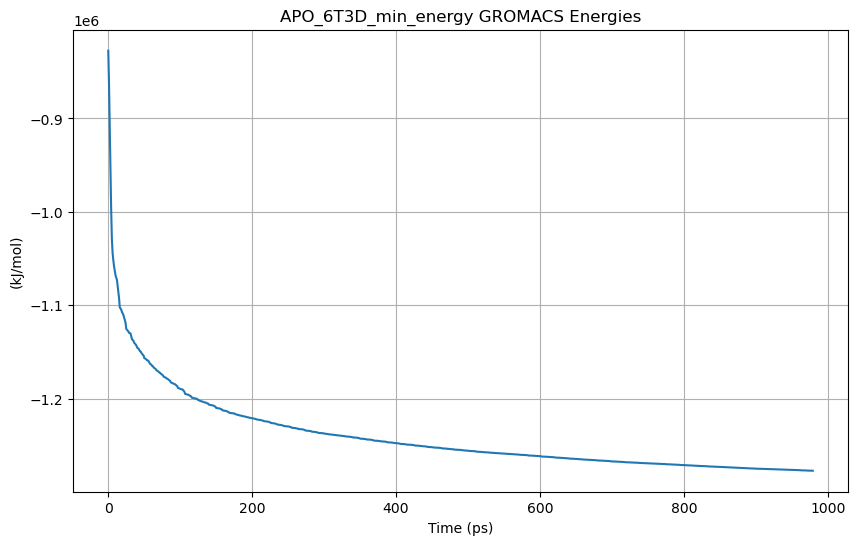

                      :-) GROMACS - gmx grompp, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /Users/alexi/Library/CloudStorage/OneDrive-Nexus365/Rotation_Projects/Rotation_2/Project/SBL_MD_CovDock
Command line:
  gmx grompp -f config/minim.mdp -c prod_structures/APO/amber14/APO_5UL8_solv_ion.gro -p prod_structures/APO/amber14/APO_5UL8.top -o prod_structures/APO/amber14/APO_5UL8_min.tpr

Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file config/minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group rest is 114120.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

There was 1 NOTE

GROMACS reminds you: "O My God, They Killed Kenny !" (South Park)

                      :-) GROM

Setting the LD random seed to 1872751063

Generated 3570 of the 3570 non-bonded parameter combinations

Generated 3570 of the 3570 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'system1'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 1 bonded neighbours molecule type 'NA'

Excluding 1 bonded neighbours molecule type 'CL'
Analysing residue names:
There are:   271    Protein residues
There are: 16952      Water residues
There are:   103        Ion residues
Analysing Protein...

The largest distance between excluded atoms is 0.422 nm between atom 679 and 680
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 72x72x72, spacing 0.114 0.114 0.114

Estimate for the relative computational load of the PME mesh part: 0.22

This run will generate roughly 4 Mb of data



Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =        50000
Step=    0, Dmax= 1.0e-02 nm, Epot= -3.14899e+05 Fmax= 3.52512e+05, atom= 54989
Step=    1, Dmax= 1.0e-02 nm, Epot= -3.64812e+05 Fmax= 1.33175e+05, atom= 54989
Step=    2, Dmax= 1.2e-02 nm, Epot= -4.36427e+05 Fmax= 4.87880e+04, atom= 33147
Step=    3, Dmax= 1.4e-02 nm, Epot= -5.12258e+05 Fmax= 2.34296e+04, atom= 44838
Step=    4, Dmax= 1.7e-02 nm, Epot= -5.69466e+05 Fmax= 1.07148e+04, atom= 44838
Step=    5, Dmax= 2.1e-02 nm, Epot= -6.19886e+05 Fmax= 5.20085e+03, atom= 44634
Step=    6, Dmax= 2.5e-02 nm, Epot= -6.58721e+05 Fmax= 1.60283e+04, atom= 2284
Step=    7, Dmax= 3.0e-02 nm, Epot= -6.68261e+05 Fmax= 2.99490e+04, atom= 2284
Step=    8, Dmax= 3.6e-02 nm, Epot= -6.78015e+05 Fmax= 2.34517e+04, atom= 2284
Step=    9, Dmax= 4.3e-02 nm, Epot= -6.82307e+05 Fmax= 4.17079e+04, atom= 2284
Step=   10, Dmax= 5.2e-02 nm, Epot= -6.87912e+05 Fmax= 3.46517e+04, atom= 2284
Step=   11, Dmax= 6.2e-02 nm, E

KeyboardInterrupt: 

In [21]:
# Perform minimisation

for pdbcode in structures.PDBID:
    # break
    # prep minimisation
    min_mdp = os.path.join(settings.config, "minim.mdp")
    input_path = os.path.join(settings.structures_output, "APO_" + pdbcode + "_solv_ion.gro")
    topo_path = os.path.join(settings.structures_output, "APO_" + pdbcode+ ".top")
    tpr_path = os.path.join(settings.structures_output, "APO_" + pdbcode + "_min.tpr")
    grompp_command = ["gmx", "grompp", "-f", min_mdp, "-c", input_path, "-p", topo_path, "-o", tpr_path]

    subprocess.run(grompp_command, check=True)

    # # Run minimization
    min_command = ["gmx", "mdrun", "-v", "-deffnm", tpr_path.replace(".tpr","")]
    subprocess.run(min_command, check=True)

    # Get energy
    energy_command = ["gmx", "energy", "-f", tpr_path.replace(".tpr",".edr"), "-o", tpr_path.replace(".tpr","_energy.xvg")]
    subprocess.run(energy_command, input="10\n".encode(), check=True)
    plot_xvg(tpr_path.replace(".tpr","_energy.xvg"))

In [8]:
#Perform nvt equilibration of the apo protein

for pdbcode in structures.PDBID:
    nvt_mdp = os.path.join(settings.config, 'nvt.mdp')
    topo_path = os.path.join(settings.structures_output, "APO_" + pdbcode+ ".top")

    input_path = os.path.join(settings.structures_output, "APO_" + pdbcode + "_min.gro")
    tpr_path = os.path.join(settings.structures_output, "APO_" + pdbcode + "_nvt.tpr")

    grompp_command = ["gmx", "grompp", "-f", nvt_mdp, "-c", input_path, "-p", topo_path, "-o", tpr_path, "-r", input_path]
    subprocess.run(grompp_command, check=True)

    mdrun_command = ["gmx", "mdrun", "-deffnm", tpr_path.replace(".tpr","")]
    subprocess.run(mdrun_command, check=True)


    energy_command = ["gmx", "energy", "-f", tpr_path.replace(".tpr",".edr"), "-o", tpr_path.replace(".tpr","_temperature.xvg")]
    subprocess.run(energy_command, input="16\n".encode(), check=True)
    
    print("Done with " + pdbcode)


                      :-) GROMACS - gmx grompp, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/alexi/Documents/SBL_MD_CovDock
Command line:
  gmx grompp -f config/nvt.mdp -c prod_structures/APO/amber14/APO_6T3D_min.gro -p prod_structures/APO/amber14/APO_6T3D.top -o prod_structures/APO/amber14/APO_6T3D_nvt.tpr -r prod_structures/APO/amber14/APO_6T3D_min.gro

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group Protein is 13961.74
Number of degrees of freedom in T-Coupling group non-Protein is 148452.27

NOTE 1 [file config/nvt.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.


There was 1 NOTE

Back Off! I just backed up prod_structures/APO/amber14/APO_6T3D

Setting the LD random seed to -889980809

Generated 3570 of the 3570 non-bonded parameter combinations

Generated 3570 of the 3570 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'system1'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -69521479

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   358    Protein residues
There are: 24668      Water residues
There are:   149        Ion residues
Analysing Protein...

The largest distance between excluded atoms is 0.418 nm between atom 396 and 403

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.034 nm, buffer size 0.034 nm

Set rlist, 

Changing nstlist from 10 to 100, rlist from 1 to 1.155

1 GPU selected for this run.
Mapping of GPU IDs to the 2 GPU tasks in the 1 rank on this node:
  PP:0,PME:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
PME tasks will do all aspects on the GPU
Using 1 MPI thread
Using 20 OpenMP threads 


Back Off! I just backed up prod_structures/APO/amber14/APO_6T3D_nvt.trr to prod_structures/APO/amber14/#APO_6T3D_nvt.trr.1#

Back Off! I just backed up prod_structures/APO/amber14/APO_6T3D_nvt.edr to prod_structures/APO/amber14/#APO_6T3D_nvt.edr.1#
starting mdrun 'Generic title in water'
50000 steps,    100.0 ps.

Writing final coordinates.

Back Off! I just backed up prod_structures/APO/amber14/APO_6T3D_nvt.gro to prod_structures/APO/amber14/#APO_6T3D_nvt.gro.1#

               Core t (s)   Wall t (s)        (%)
       Time:      965.542       48.279     1999.9
                 (ns/day)    (hour/ns)
Performance:  


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 299.893       0.22    3.13414   0.919234  (K)
Done with 6T3D


Number of degrees of freedom in T-Coupling group Protein is 10093.73
Number of degrees of freedom in T-Coupling group non-Protein is 102018.27

NOTE 1 [file config/nvt.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.


There was 1 NOTE

Back Off! I just backed up prod_structures/APO/amber14/APO_5UL8_nvt.tpr to prod_structures/APO/amber14/#APO_5UL8_nvt.tpr.1#

GROMACS reminds you: "I invented the term 'Object-Oriented', and I can tell you I did not have C++ in mind." (Alan Kay, author of Smalltalk)

                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/alexi/Documents/SBL_MD_CovDock
Command line:
  gmx mdrun -deffnm prod_structures/APO/amber14/APO_5UL8_nvt


Back Off! I just backed up prod_structures/APO/amber14/APO_5UL8_nvt.l

Setting the LD random seed to -570490881

Generated 3570 of the 3570 non-bonded parameter combinations

Generated 3570 of the 3570 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'system1'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to 972332735

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   271    Protein residues
There are: 16952      Water residues
There are:   103        Ion residues
Analysing Protein...

The largest distance between excluded atoms is 0.423 nm between atom 679 and 680

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.034 nm, buffer size 0.034 nm

Set rlist, 

Changing nstlist from 10 to 100, rlist from 1 to 1.155

1 GPU selected for this run.
Mapping of GPU IDs to the 2 GPU tasks in the 1 rank on this node:
  PP:0,PME:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
PME tasks will do all aspects on the GPU
Using 1 MPI thread
Using 20 OpenMP threads 


Back Off! I just backed up prod_structures/APO/amber14/APO_5UL8_nvt.trr to prod_structures/APO/amber14/#APO_5UL8_nvt.trr.1#

Back Off! I just backed up prod_structures/APO/amber14/APO_5UL8_nvt.edr to prod_structures/APO/amber14/#APO_5UL8_nvt.edr.1#
starting mdrun 'Generic title in water'
50000 steps,    100.0 ps.

Writing final coordinates.

Back Off! I just backed up prod_structures/APO/amber14/APO_5UL8_nvt.gro to prod_structures/APO/amber14/#APO_5UL8_nvt.gro.1#

               Core t (s)   Wall t (s)        (%)
       Time:      775.245       38.765     1999.9
                 (ns/day)    (hour/ns)
Performance:  


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 299.644       0.23    3.16818    1.45094  (K)
Done with 5UL8


Number of degrees of freedom in T-Coupling group Protein is 9678.70
Number of degrees of freedom in T-Coupling group non-Protein is 86595.30

NOTE 1 [file config/nvt.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.


There was 1 NOTE

Back Off! I just backed up prod_structures/APO/amber14/APO_1K55_nvt.tpr to prod_structures/APO/amber14/#APO_1K55_nvt.tpr.1#

GROMACS reminds you: "You cannot hope to build a better world without improving the individuals." (Marie Curie)

                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/alexi/Documents/SBL_MD_CovDock
Command line:
  gmx mdrun -deffnm prod_structures/APO/amber14/APO_1K55_nvt


Back Off! I just backed up prod_structures/APO/amber14/APO_1K55_nvt.log to prod_structures/APO/amber

Setting the LD random seed to 1068400407

Generated 3570 of the 3570 non-bonded parameter combinations

Generated 3570 of the 3570 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'system1'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -340263042

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   245    Protein residues
There are: 14389      Water residues
There are:    88        Ion residues
Analysing Protein...

The largest distance between excluded atoms is 0.423 nm between atom 3443 and 3451

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.034 nm, buffer size 0.034 nm

Set rlis

Changing nstlist from 10 to 100, rlist from 1 to 1.155

Update groups can not be used for this system because atoms that are (in)directly constrained together are interdispersed with other atoms

1 GPU selected for this run.
Mapping of GPU IDs to the 2 GPU tasks in the 1 rank on this node:
  PP:0,PME:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
PME tasks will do all aspects on the GPU
Using 1 MPI thread
Using 20 OpenMP threads 


Back Off! I just backed up prod_structures/APO/amber14/APO_1K55_nvt.trr to prod_structures/APO/amber14/#APO_1K55_nvt.trr.1#

Back Off! I just backed up prod_structures/APO/amber14/APO_1K55_nvt.edr to prod_structures/APO/amber14/#APO_1K55_nvt.edr.1#
starting mdrun 'Generic title in water'
50000 steps,    100.0 ps.



Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 299.664       0.27    2.99595    1.74406  (K)
Done with 1K55



Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:      624.446       31.224     1999.9
                 (ns/day)    (hour/ns)
Performance:      276.717        0.087

GROMACS reminds you: "Hold On Like Cliffhanger" (Urban Dance Squad)

                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/alexi/Documents/SBL_MD_CovDock
Command line:
  gmx energy -f prod_structures/APO/amber14/APO_1K55_nvt.edr -o prod_structures/APO/amber14/APO_1K55_nvt_temperature.xvg

Opened prod_structures/APO/amber14/APO_1K55_nvt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Per.-Imp.-Dih.

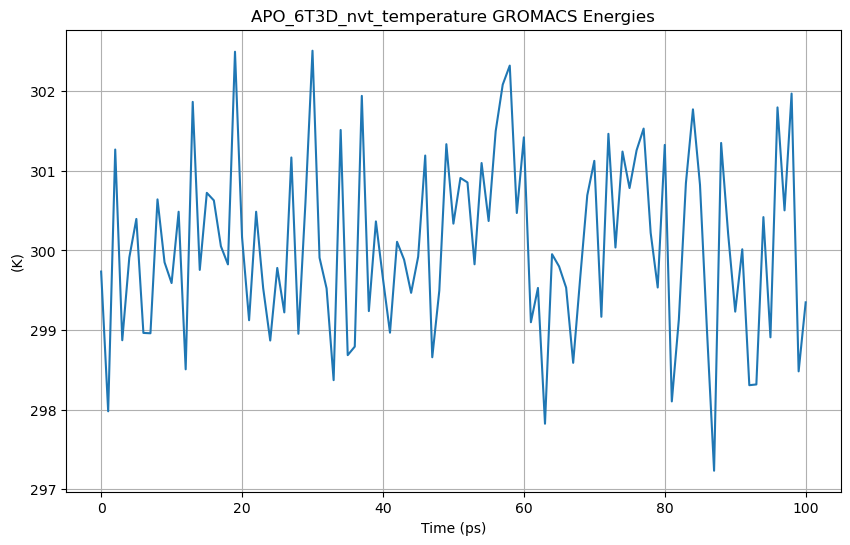

Done with 6T3D


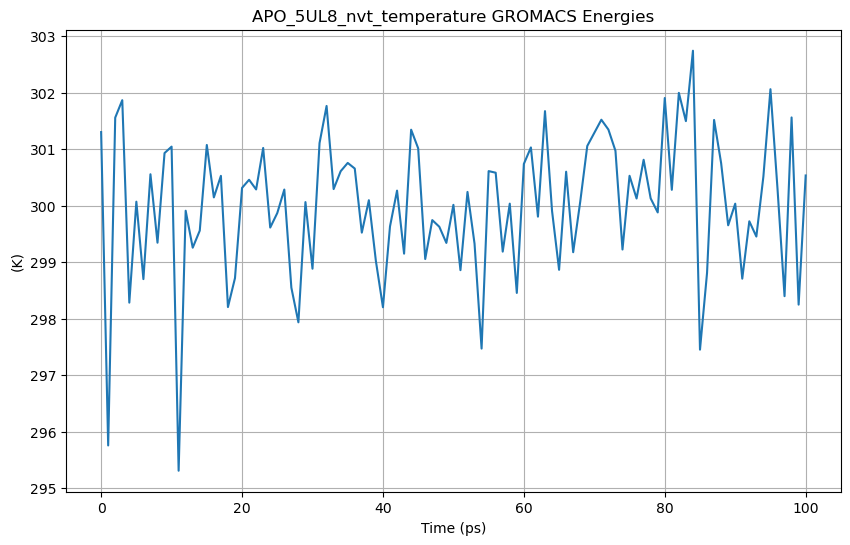

Done with 5UL8


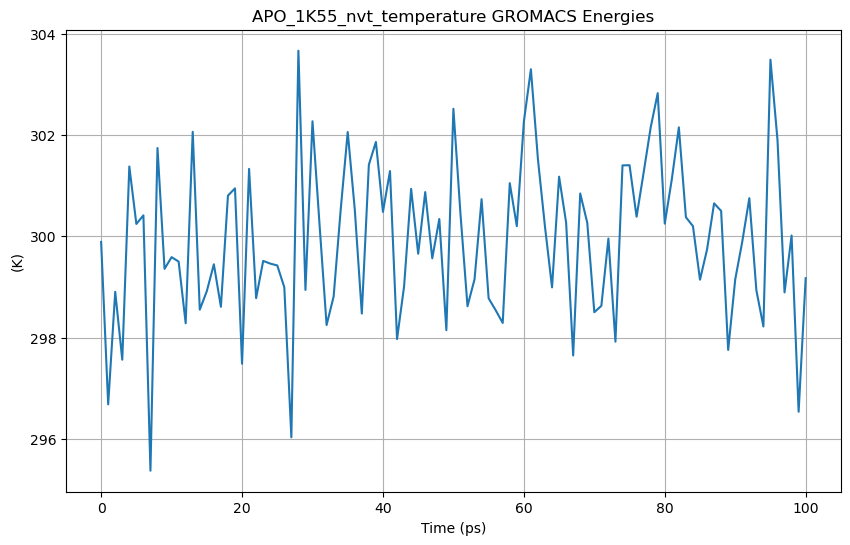

Done with 1K55


In [9]:
#Perform nvt equilibration of the apo protein

for pdbcode in structures.PDBID:
    nvt_mdp = os.path.join(settings.config, 'nvt.mdp')
    topo_path = os.path.join(settings.structures_output, "APO_" + pdbcode+ ".top")

    input_path = os.path.join(settings.structures_output, "APO_" + pdbcode + "_min.gro")
    tpr_path = os.path.join(settings.structures_output, "APO_" + pdbcode + "_nvt.tpr")

    # grompp_command = ["gmx", "grompp", "-f", nvt_mdp, "-c", input_path, "-p", topo_path, "-o", tpr_path, "-r", input_path]
    # subprocess.run(grompp_command, check=True)

    # mdrun_command = ["gmx", "mdrun", "-deffnm", tpr_path.replace(".tpr","")]
    # subprocess.run(mdrun_command, check=True)


    # energy_command = ["gmx", "energy", "-f", tpr_path.replace(".tpr",".edr"), "-o", tpr_path.replace(".tpr","_temperature.xvg")]
    # subprocess.run(energy_command, input="16\n".encode(), check=True)
    plot_xvg(tpr_path.replace(".tpr","_temperature.xvg"))

    print("Done with " + pdbcode)


In [10]:
#Perform npt equilibration of the apo protein

for pdbcode in structures.PDBID:
    npt_mdp = os.path.join(settings.config, 'npt.mdp')
    topo_path = os.path.join(settings.structures_output, "APO_" + pdbcode+ ".top")

    input_path = os.path.join(settings.structures_output, "APO_" + pdbcode + "_nvt.gro")
    tpr_path = os.path.join(settings.structures_output, "APO_" + pdbcode + "_npt.tpr")

    grompp_command = ["gmx", "grompp", "-f", npt_mdp, "-c", input_path, "-p", topo_path, "-o", tpr_path, "-r", input_path]

    subprocess.run(grompp_command, check=True)

    mdrun_command = ["gmx", "mdrun", "-deffnm", tpr_path.replace(".tpr","")]
    subprocess.run(mdrun_command, check=True)

    energy_command = ["gmx", "energy", "-f", tpr_path.replace(".tpr",".edr"), "-o", tpr_path.replace(".tpr","_pressure.xvg")]

    subprocess.run(energy_command, input="18\n".encode(), check=True)

    energy_command = ["gmx", "energy", "-f", tpr_path.replace(".tpr",".edr"), "-o", tpr_path.replace(".tpr","_density.xvg")]

    subprocess.run(energy_command, input="24\n".encode(), check=True)
    print("Done with " + pdbcode)


                      :-) GROMACS - gmx grompp, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/alexi/Documents/SBL_MD_CovDock
Command line:
  gmx grompp -f config/npt.mdp -c prod_structures/APO/amber14/APO_6T3D_nvt.gro -p prod_structures/APO/amber14/APO_6T3D.top -o prod_structures/APO/amber14/APO_6T3D_npt.tpr -r prod_structures/APO/amber14/APO_6T3D_nvt.gro

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5

NOTE 1 [file APO_6T3D.top, line 61998]:
  You are combining position restraints with Parrinello-Rahman pressure
  coupling, which can lead to instabilities. If you really want to combine
  position restraints with pressure coupling, we suggest to use Berendsen
  pressure coupling instead.

Number of degrees of freedom in T-Coupling group Protein is 13961.74
Number of degrees of freedom in T-Coupling group non-Protein is 148452.27

NOTE 2 [file config/npt.mdp]:


Setting the LD random seed to -69255173

Generated 3570 of the 3570 non-bonded parameter combinations

Generated 3570 of the 3570 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'system1'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The center of mass of the position restraint coord's is  4.663  4.664  4.659

The center of mass of the position restraint coord's is  4.663  4.664  4.659
Analysing residue names:
There are:   358    Protein residues
There are: 24668      Water residues
There are:   149        Ion residues
Analysing Protein...

The largest distance between excluded atoms is 0.420 nm between atom 5203 and 5211

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for

Changing nstlist from 10 to 100, rlist from 1 to 1.155

1 GPU selected for this run.
Mapping of GPU IDs to the 2 GPU tasks in the 1 rank on this node:
  PP:0,PME:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
PME tasks will do all aspects on the GPU
Using 1 MPI thread
Using 20 OpenMP threads 

starting mdrun 'Generic title in water'
50000 steps,    100.0 ps.

Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:      985.408       49.272     1999.9
                 (ns/day)    (hour/ns)
Performance:      175.357        0.137

GROMACS reminds you: "Studying expands knowledge. Knowledge is power. Power corrupts. Corruption is a crime. Crime doesn't pay." (Anonymous)

                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/alexi/Documents/SBL_MD_CovDock
Command line:
  gmx en


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                   -1.37033          3    111.543    1.53061  (bar)

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     1015.48       0.17    3.51756   0.433839  (kg/m^3)
Done with 6T3D



NOTE 1 [file APO_5UL8.top, line 44621]:
  You are combining position restraints with Parrinello-Rahman pressure
  coupling, which can lead to instabilities. If you really want to combine
  position restraints with pressure coupling, we suggest to use Berendsen
  pressure coupling instead.

Number of degrees of freedom in T-Coupling group Protein is 10093.73
Number of degrees of freedom in T-Coupling group non-Protein is 102018.27

NOTE 2 [file config/npt.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.


There were 2 NOTEs

GROMACS reminds you: "Studying expands knowledge. Knowledge is power. Power corrupts. Corruption is a crime. Crime doesn't pay." (Anonymous)

                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/alexi/Do

Setting the LD random seed to -1201237

Generated 3570 of the 3570 non-bonded parameter combinations

Generated 3570 of the 3570 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'system1'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The center of mass of the position restraint coord's is  4.109  4.121  4.112

The center of mass of the position restraint coord's is  4.109  4.121  4.112
Analysing residue names:
There are:   271    Protein residues
There are: 16952      Water residues
There are:   103        Ion residues
Analysing Protein...

The largest distance between excluded atoms is 0.429 nm between atom 22 and 30

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 

Reading file prod_structures/APO/amber14/APO_5UL8_npt.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 10 to 100, rlist from 1 to 1.155

1 GPU selected for this run.
Mapping of GPU IDs to the 2 GPU tasks in the 1 rank on this node:
  PP:0,PME:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
PME tasks will do all aspects on the GPU
Using 1 MPI thread
Using 20 OpenMP threads 

starting mdrun 'Generic title in water'
50000 steps,    100.0 ps.

Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:      722.982       36.150     1999.9
                 (ns/day)    (hour/ns)
Performance:      239.006        0.100

GROMACS reminds you: "Microbiology Lab - Staph Only." (Anonymous)

                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/alexi/Documents/SBL_MD_CovDock
Comm


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                   -6.26361        5.2    145.578   -7.44521  (bar)

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     1017.94       0.25    4.84385   0.846368  (kg/m^3)
Done with 5UL8



NOTE 1 [file APO_1K55.top, line 42765]:
  You are combining position restraints with Parrinello-Rahman pressure
  coupling, which can lead to instabilities. If you really want to combine
  position restraints with pressure coupling, we suggest to use Berendsen
  pressure coupling instead.

Number of degrees of freedom in T-Coupling group Protein is 9678.70
Number of degrees of freedom in T-Coupling group non-Protein is 86595.30

NOTE 2 [file config/npt.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.


There were 2 NOTEs

GROMACS reminds you: "Microbiology Lab - Staph Only." (Anonymous)

                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/alexi/Documents/SBL_MD_CovDock
Command line:
  gmx mdrun -deffnm prod_structures/APO/

Setting the LD random seed to -105250817

Generated 3570 of the 3570 non-bonded parameter combinations

Generated 3570 of the 3570 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'system1'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The center of mass of the position restraint coord's is  3.918  3.887  3.918

The center of mass of the position restraint coord's is  3.918  3.887  3.918
Analysing residue names:
There are:   245    Protein residues
There are: 14389      Water residues
There are:    88        Ion residues
Analysing Protein...

The largest distance between excluded atoms is 0.427 nm between atom 1201 and 1209

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist fo

Reading file prod_structures/APO/amber14/APO_1K55_npt.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 10 to 100, rlist from 1 to 1.155

Update groups can not be used for this system because atoms that are (in)directly constrained together are interdispersed with other atoms

1 GPU selected for this run.
Mapping of GPU IDs to the 2 GPU tasks in the 1 rank on this node:
  PP:0,PME:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
PME tasks will do all aspects on the GPU
Using 1 MPI thread
Using 20 OpenMP threads 

starting mdrun 'Generic title in water'
50000 steps,    100.0 ps.



Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                    5.95619        2.1    154.368   -11.8444  (bar)

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     1021.59       0.12     4.5831  -0.592626  (kg/m^3)
Done with 1K55



Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:      649.768       32.491     1999.8
                 (ns/day)    (hour/ns)
Performance:      265.924        0.090

GROMACS reminds you: "What do you call an acid with an attitude? A-mean-oh acid." (Anonymous)

                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/alexi/Documents/SBL_MD_CovDock
Command line:
  gmx energy -f prod_structures/APO/amber14/APO_1K55_npt.edr -o prod_structures/APO/amber14/APO_1K55_npt_pressure.xvg

Opened prod_structures/APO/amber14/APO_1K55_npt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.

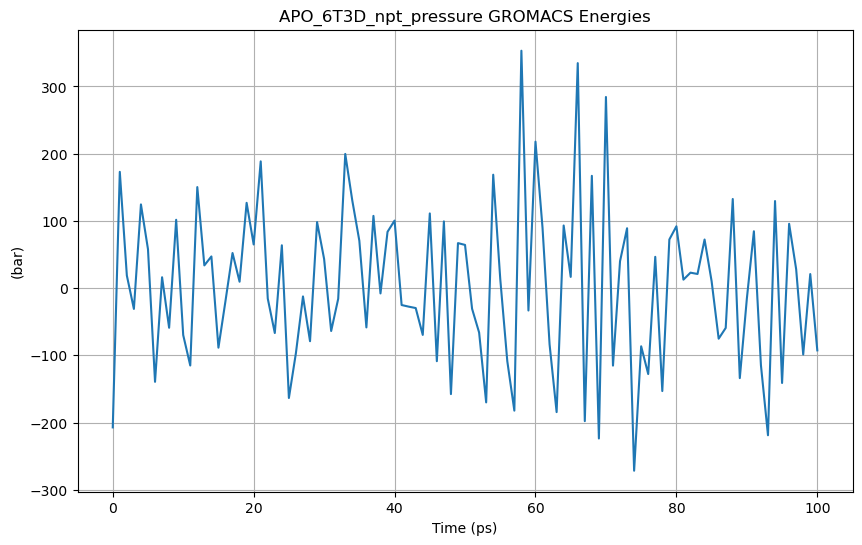

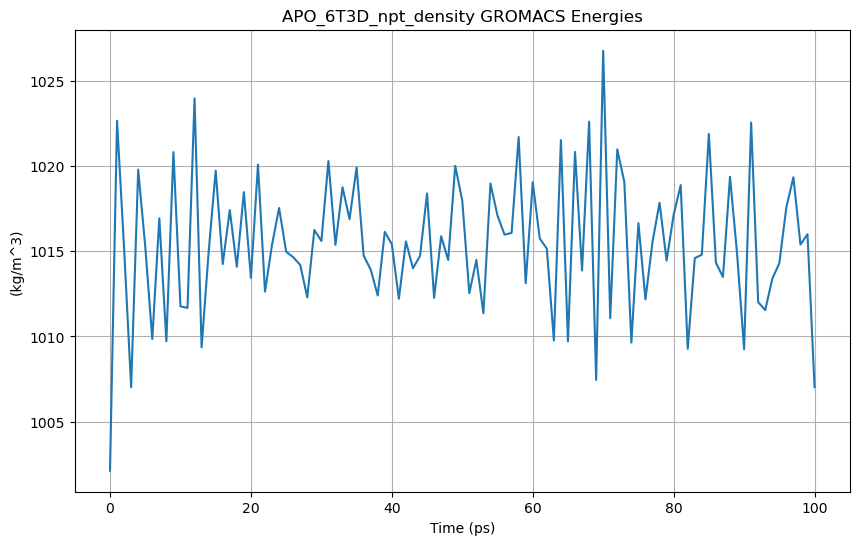

Done with 6T3D


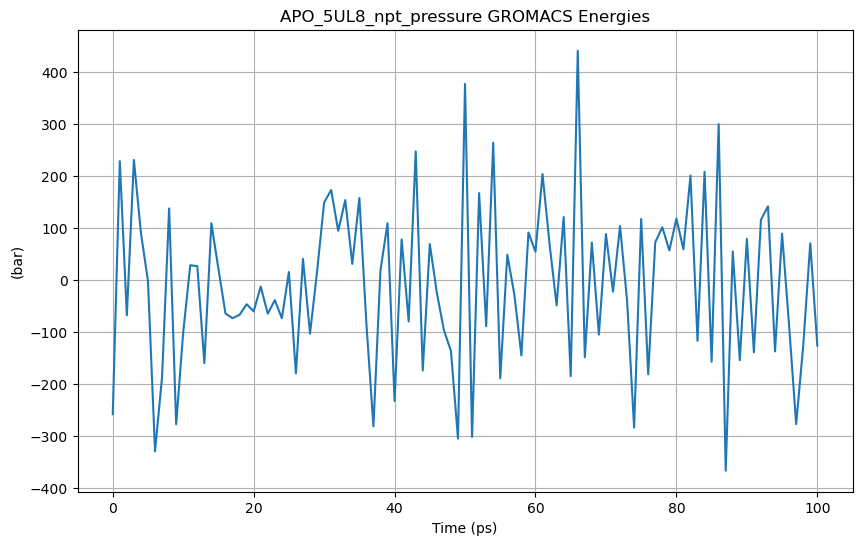

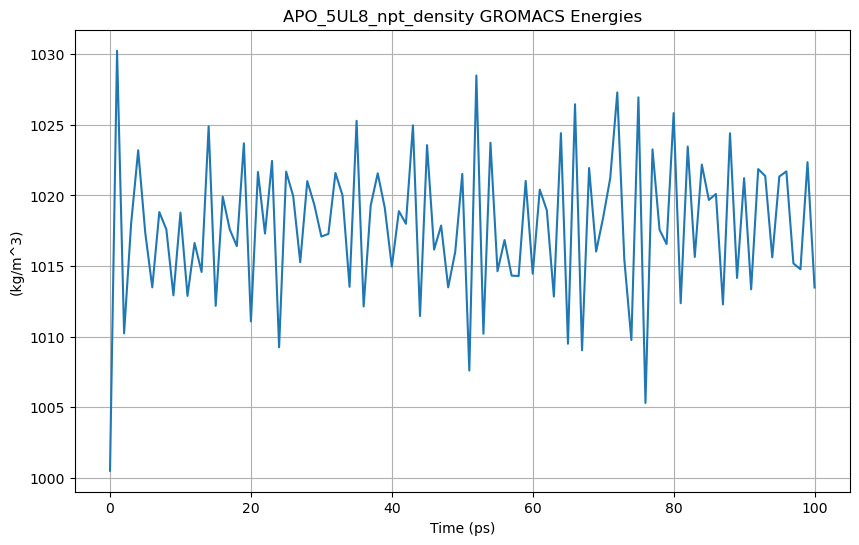

Done with 5UL8


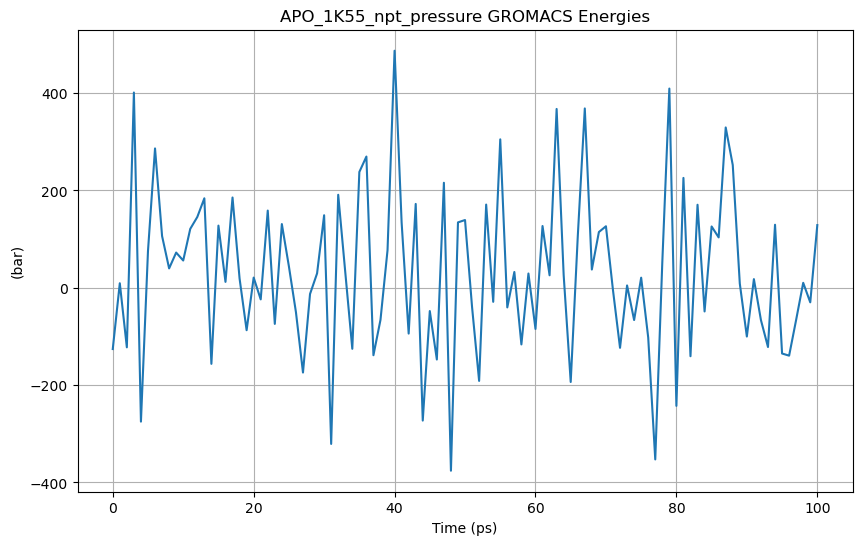

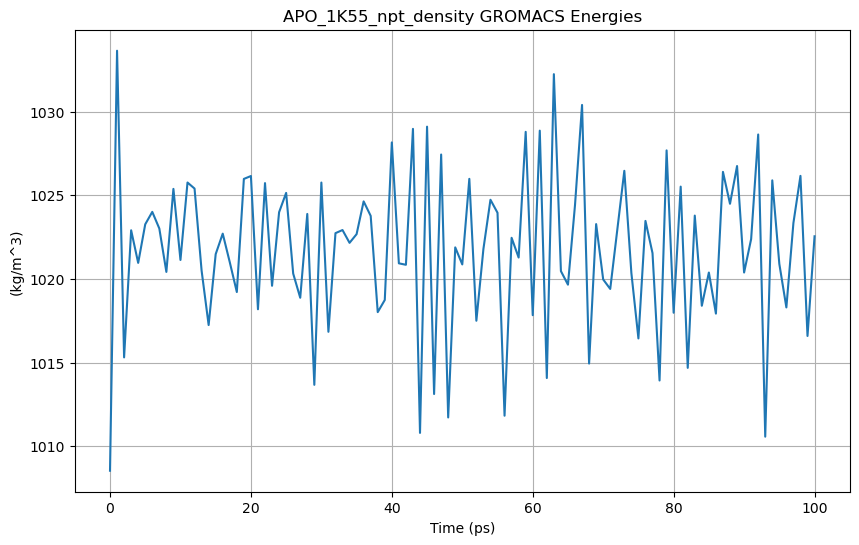

Done with 1K55


In [12]:
#Plot npt equilibration of the apo protein

for pdbcode in structures.PDBID:
    npt_mdp = os.path.join(settings.config, 'npt.mdp')
    topo_path = os.path.join(settings.structures_output, "APO_" + pdbcode+ ".top")

    input_path = os.path.join(settings.structures_output, "APO_" + pdbcode + "_nvt.gro")
    tpr_path = os.path.join(settings.structures_output, "APO_" + pdbcode + "_npt.tpr")

    # grompp_command = ["gmx", "grompp", "-f", npt_mdp, "-c", input_path, "-p", topo_path, "-o", tpr_path, "-r", input_path]

    # subprocess.run(grompp_command, check=True)

    # mdrun_command = ["gmx", "mdrun", "-deffnm", tpr_path.replace(".tpr","")]
    # subprocess.run(mdrun_command, check=True)

    # energy_command = ["gmx", "energy", "-f", tpr_path.replace(".tpr",".edr"), "-o", tpr_path.replace(".tpr","_pressure.xvg")]

    # subprocess.run(energy_command, input="18\n".encode(), check=True)

    # energy_command = ["gmx", "energy", "-f", tpr_path.replace(".tpr",".edr"), "-o", tpr_path.replace(".tpr","_density.xvg")]

    # subprocess.run(energy_command, input="24\n".encode(), check=True)

    plot_xvg(tpr_path.replace(".tpr","_pressure.xvg"))
    plot_xvg(tpr_path.replace(".tpr","_density.xvg"))
    print("Done with " + pdbcode)